# Modelos de ML

**Objetivo**: Criar modelos de ML para a projeção de todas as nossas séries.

**Metodologias**: 

- Regressão Linear
- Árvore de decisão
- Random Forest
- XGBoost
- LightGBM

## 0. Setup

In [1]:
%load_ext autotime

time: 240 µs (started: 2024-01-16 09:35:05 -03:00)


In [2]:
#---- Manipulação de dados:

import pandas as pd
import numpy as np

#---- Modelagem:

from hierarchicalforecast.utils import aggregate
from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#---- Reconciliação

from hierarchicalforecast.methods import BottomUp, TopDown, ERM, OptimalCombination, MinTrace, MiddleOut
from hierarchicalforecast.core import HierarchicalReconciliation

#---- Visualização

import plotly.express as px

time: 4.65 s (started: 2024-01-16 09:35:05 -03:00)


In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

time: 358 µs (started: 2024-01-16 09:35:09 -03:00)


## 1. Dados: vendas de roupas no varejo

In [4]:
dados = pd.read_csv('https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-hierarchical-forecasting/main/retail-usa-clothing.csv')

dados.head()

date    state           item  quantity       region country
0  1997-11-25  NewYork  mens_clothing         8  Mid-Alantic     USA
1  1997-11-26  NewYork  mens_clothing         9  Mid-Alantic     USA
2  1997-11-27  NewYork  mens_clothing        11  Mid-Alantic     USA
3  1997-11-28  NewYork  mens_clothing        11  Mid-Alantic     USA
4  1997-11-29  NewYork  mens_clothing        10  Mid-Alantic     USA

time: 1.64 s (started: 2024-01-16 09:35:09 -03:00)


In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388024 entries, 0 to 388023
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      388024 non-null  object
 1   state     388024 non-null  object
 2   item      388024 non-null  object
 3   quantity  388024 non-null  int64 
 4   region    388024 non-null  object
 5   country   388024 non-null  object
dtypes: int64(1), object(5)
memory usage: 17.8+ MB
time: 71.7 ms (started: 2024-01-16 09:35:11 -03:00)


## 2. Modificação nos dados 

In [6]:
def clean_data_baseline(df: pd.DataFrame):

    #---- 1. Excluindo a variável de country:

    df = df\
        .drop(columns = 'country')

    #---- 2. Mudando o tipo da variável de date para datetime:

    df['date'] = pd.to_datetime(df['date'])

    #---- 3. Renomeando as variáveis de quantidade de vendas e data:
    # date -> ds
    # quantity -> y

    df = df\
        .rename(columns = {'date': 'ds', 
                           'quantity': 'y'})

    return df

time: 533 µs (started: 2024-01-16 09:35:11 -03:00)


In [7]:
df = clean_data_baseline(df = dados)

df.head()

ds    state           item   y       region
0 1997-11-25  NewYork  mens_clothing   8  Mid-Alantic
1 1997-11-26  NewYork  mens_clothing   9  Mid-Alantic
2 1997-11-27  NewYork  mens_clothing  11  Mid-Alantic
3 1997-11-28  NewYork  mens_clothing  11  Mid-Alantic
4 1997-11-29  NewYork  mens_clothing  10  Mid-Alantic

time: 100 ms (started: 2024-01-16 09:35:11 -03:00)


In [8]:
def format_hierarchical_df(df: pd.DataFrame, cols_hierarchical: list):

    #---- 1. Cria uma lista de listas: [[col1], [col1, col2], ..., [col1, col2, coln]]

    hier_list = [cols_hierarchical[:i] for i in range(1, len(cols_hierarchical) + 1)]

    #---- 2. Aplica a função aggregate que formata os dados em que a lib hierarchical pede

    Y_df, S_df, tags = aggregate(df = df, spec = hier_list)

    return Y_df, S_df, tags

time: 664 µs (started: 2024-01-16 09:35:11 -03:00)


In [9]:
cols_hierarchical = ['region', 'state', 'item']

Y_df, S_df, tags = format_hierarchical_df(df = df, cols_hierarchical = cols_hierarchical)

time: 637 ms (started: 2024-01-16 09:35:11 -03:00)


In [10]:
display(Y_df.head())
display(Y_df.tail())

ds    y
unique_id                       
EastNorthCentral 1997-11-25  507
EastNorthCentral 1997-11-26  504
EastNorthCentral 1997-11-27  510
EastNorthCentral 1997-11-28  507
EastNorthCentral 1997-11-29  513

ds   y
unique_id                                         
SouthCentral/Tennessee/womens_shoes 2009-07-24  31
SouthCentral/Tennessee/womens_shoes 2009-07-25  30
SouthCentral/Tennessee/womens_shoes 2009-07-26  31
SouthCentral/Tennessee/womens_shoes 2009-07-27  29
SouthCentral/Tennessee/womens_shoes 2009-07-28  30

time: 9.88 ms (started: 2024-01-16 09:35:12 -03:00)


In [11]:
S_df

EastNorthCentral/Illinois/kids_clothing  \
EastNorthCentral                                                          1.000   
Mid-Alantic                                                               0.000   
NewEngland                                                                0.000   
Pacific                                                                   0.000   
SouthCentral                                                              0.000   
...                                                                         ...   
SouthCentral/Tennessee/kids_clothing                                      0.000   
SouthCentral/Tennessee/kids_shoes                                         0.000   
SouthCentral/Tennessee/mens_clothing                                      0.000   
SouthCentral/Tennessee/womens_clothing                                    0.000   
SouthCentral/Tennessee/womens_shoes                                       0.000   

                                        EastNorthCentral/Illinois/kids_shoes  \
EastNorthCentral                                                       1.000   
Mid-Alantic                                                            0.000   
NewEngland                                                             0.000   
Pacific                                                                0.000   
SouthCentral                                                           0.000   
...                                                                      ...   
SouthCentral/Tennessee/kids_clothing                                   0.000   
SouthCentral/Tennessee/kids_shoes                                      0.000   
SouthCentral/Tennessee/mens_clothing                                   0.000   
SouthCentral/Tennessee/womens_clothing                                 0.000   
SouthCentral/Tennessee/womens_shoes                                    0.000   

                                        EastNorthCentral/Illinois/mens_clothing  \
EastNorthCentral                                                          1.000   
Mid-Alantic                                                               0.000   
NewEngland                                                                0.000   
Pacific                                                                   0.000   
SouthCentral                                                              0.000   
...                                                                         ...   
SouthCentral/Tennessee/kids_clothing                                      0.000   
SouthCentral/Tennessee/kids_shoes                                         0.000   
SouthCentral/Tennessee/mens_clothing                                      0.000   
SouthCentral/Tennessee/womens_clothing                                    0.000   
SouthCentral/Tennessee/womens_shoes                                       0.000   

                                        EastNorthCentral/Illinois/womens_clothing  \
EastNorthCentral                                                            1.000   
Mid-Alantic                                                                 0.000   
NewEngland                                                                  0.000   
Pacific                                                                     0.000   
SouthCentral                                                                0.000   
...                                                                           ...   
SouthCentral/Tennessee/kids_clothing                                        0.000   
SouthCentral/Tennessee/kids_shoes                                           0.000   
SouthCentral/Tennessee/mens_clothing                                        0.000   
SouthCentral/Tennessee/womens_clothing                                      0.000   
SouthCentral/Tennessee/womens_shoes                                         0.000   

                                        EastNorthCentral/Illinoi

time: 17 ms (started: 2024-01-16 09:35:12 -03:00)


- **Dados de treino: 25/11/1997 a 31/12/2008**
- **Dados de validação: 01/01/2009 a 28/07/2009**

In [12]:
def split_train_test(df: pd.DataFrame, dt_start_train: str):

    #---- 1. Dados de treino

    train = df.query(f'ds < "{dt_start_train}"')

    #---- 2. Dados de teste:
    
    valid = df.query(f'ds >= "{dt_start_train}"')

    return train, valid

time: 1.34 ms (started: 2024-01-16 09:35:12 -03:00)


In [13]:
Y_train_df, Y_valid_df = split_train_test(df = Y_df, dt_start_train = '2009-01-01')

time: 76.6 ms (started: 2024-01-16 09:35:12 -03:00)


In [14]:
display(Y_train_df.head())
display(Y_train_df.tail())

ds    y
unique_id                       
EastNorthCentral 1997-11-25  507
EastNorthCentral 1997-11-26  504
EastNorthCentral 1997-11-27  510
EastNorthCentral 1997-11-28  507
EastNorthCentral 1997-11-29  513

ds   y
unique_id                                         
SouthCentral/Tennessee/womens_shoes 2008-12-27  31
SouthCentral/Tennessee/womens_shoes 2008-12-28  29
SouthCentral/Tennessee/womens_shoes 2008-12-29  28
SouthCentral/Tennessee/womens_shoes 2008-12-30  31
SouthCentral/Tennessee/womens_shoes 2008-12-31  31

time: 8.91 ms (started: 2024-01-16 09:35:12 -03:00)


## 3. Modelagem

### 3.1. Fit do modelo

In [15]:
import json

#---- Lendo os arquivos de hiperparâmetros dos modelos

with open('../../03-best-params/decision-tree-best-parameters.json', 'r') as read_file:
    dt_params = json.load(read_file)
with open('../../03-best-params/random-forest-best-parameters.json', 'r') as read_file:
    rf_params = json.load(read_file)
with open('../../03-best-params/lgbm-best-parameters.json', 'r') as read_file:
    lgbm_params = json.load(read_file)
with open('../../03-best-params/xgboost-best-parameters.json', 'r') as read_file:
    xgb_params = json.load(read_file)    

#---- Adicionando o parâmetro de Random State nos dicionários:

dt_params['random_state'] = 19
rf_params['random_state'] = 19
rf_params['n_estimators'] = 100
lgbm_params['random_state'] = 19
lgbm_params['n_estimators'] = 100
xgb_params['random_state'] = 19
xgb_params['n_estimators'] = 100

time: 17.1 ms (started: 2024-01-16 09:35:12 -03:00)


In [16]:
#---- Modelos:

lin_reg = LinearRegression() # Regressão linear

dec_tree = DecisionTreeRegressor(random_state = 19) # Árvore de decisão
tun_dec_tree = DecisionTreeRegressor(**dt_params) # Árvore de decisão tunada

ran_forest = RandomForestRegressor(random_state = 19, n_estimators = 500) # Random Forest
tun_ran_forest = RandomForestRegressor(**rf_params)

lgbm = LGBMRegressor(random_state = 19, n_estimators = 500) # LightGBM
tun_lgbm = LGBMRegressor(**lgbm_params) # LightGBM

xgb = XGBRegressor(random_state = 19, n_estimators = 500) # XGBoost
tun_xgb = XGBRegressor(**xgb_params) # XGBoost

models_list = [lin_reg, dec_tree, tun_dec_tree, ran_forest, tun_ran_forest, lgbm, tun_lgbm, xgb, tun_xgb]

# models_list = [lin_reg, tun_ran_forest, lgbm, tun_lgbm]

time: 1.03 ms (started: 2024-01-16 09:35:12 -03:00)


In [17]:
#---- Features de data:

from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size = 7)

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size = 14)

@njit
def rolling_mean_21(x):
    return rolling_mean(x, window_size = 21)

@njit
def rolling_mean_28(x):
    return rolling_mean(x, window_size = 28)

time: 10.4 ms (started: 2024-01-16 09:35:12 -03:00)


In [18]:
models_list = [lin_reg, dec_tree, tun_dec_tree, ran_forest, tun_ran_forest, lgbm, tun_lgbm, xgb, tun_xgb]

model = MLForecast(models = models_list, # Lista com 9 modelos
                   freq = 'D', # Frequência diária
                   num_threads = 6,
                   lags = [1, 7, 14, 21, 28, 30], # Criação de novas features de lags de 1, 7, ..., 30 dias da variável resposta
                   date_features = ['dayofweek', 'month', 'year', 'quarter', 'day', 'week'], # Features de data
                   lag_transforms = {
                       1: [expanding_mean],
                       7: [rolling_mean_7],
                       14: [rolling_mean_14],
                       21: [rolling_mean_21],
                       28: [rolling_mean_28],
                   }
           )

model.fit(Y_train_df.reset_index(), id_col = 'unique_id', time_col = 'ds', target_col = 'y', fitted = True)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2928
[LightGBM] [Info] Number of data points in the train set: 456000, number of used features: 17
[LightGBM] [Info] Start training from score 116.233066
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2928
[LightGBM] [Info] Number of data points in the train set: 456000, number of used featur

MLForecast(models=[LinearRegression, DecisionTreeRegressor, DecisionTreeRegressor2, RandomForestRegressor, RandomForestRegressor2, LGBMRegressor, LGBMRegressor2, XGBRegressor, XGBRegressor2], freq=D, lag_features=['lag1', 'lag7', 'lag14', 'lag21', 'lag28', 'lag30', 'expanding_mean_lag1', 'rolling_mean_7_lag7', 'rolling_mean_14_lag14', 'rolling_mean_21_lag21', 'rolling_mean_28_lag28'], date_features=['dayofweek', 'month', 'year', 'quarter', 'day', 'week'], num_threads=6)

time: 45min 53s (started: 2024-01-16 09:35:12 -03:00)


In [49]:
Y_train_df\
    .reset_index()\
    .groupby('unique_id', as_index = False)['ds']\
    .min()

unique_id         ds
0                           EastNorthCentral 1997-11-25
1                  EastNorthCentral/Illinois 1997-11-25
2    EastNorthCentral/Illinois/kids_clothing 1997-11-25
3       EastNorthCentral/Illinois/kids_shoes 1997-11-25
4    EastNorthCentral/Illinois/mens_clothing 1997-11-25
..                                       ...        ...
109     SouthCentral/Tennessee/kids_clothing 1997-11-25
110        SouthCentral/Tennessee/kids_shoes 1997-11-25
111     SouthCentral/Tennessee/mens_clothing 1997-11-25
112   SouthCentral/Tennessee/womens_clothing 1997-11-25
113      SouthCentral/Tennessee/womens_shoes 1997-11-25

[114 rows x 2 columns]

time: 63.9 ms (started: 2024-01-16 11:28:04 -03:00)


In [66]:
#---- Validando que os dados estão começando a ser treinados a partir de um dia diferente do início da série

# Y_train_df\
#     .reset_index()\
#     .groupby('unique_id', as_index = False)['ds']\
#     .min()\
#     .merge(
#         model.preprocess(Y_train_df.reset_index())\
#         .groupby('unique_id', as_index = False)['ds']\
#         .min(), 
#     on = 'unique_id', how = 'left')\
#     .assign(\
#         is_ds_equal = lambda x: np.where(x['ds_x'] == x['ds_y'], True, False)
#     )['is_ds_equal']\
#     .value_counts()

is_ds_equal
False    114
Name: count, dtype: int64

time: 585 ms (started: 2024-01-16 11:35:35 -03:00)


In [42]:
model.preprocess(Y_train_df.reset_index())\
    .sort_values(by = ['unique_id', 'ds'])

unique_id         ds       y    lag1  \
55                         EastNorthCentral 1998-01-19 561.000 552.000   
56                         EastNorthCentral 1998-01-20 564.000 561.000   
57                         EastNorthCentral 1998-01-21 552.000 564.000   
58                         EastNorthCentral 1998-01-22 547.000 552.000   
59                         EastNorthCentral 1998-01-23 552.000 547.000   
...                                     ...        ...     ...     ...   
462265  SouthCentral/Tennessee/womens_shoes 2008-12-27  31.000  31.000   
462266  SouthCentral/Tennessee/womens_shoes 2008-12-28  29.000  31.000   
462267  SouthCentral/Tennessee/womens_shoes 2008-12-29  28.000  29.000   
462268  SouthCentral/Tennessee/womens_shoes 2008-12-30  31.000  28.000   
462269  SouthCentral/Tennessee/womens_shoes 2008-12-31  31.000  31.000   

          lag7   lag14   lag21   lag28   lag30  expanding_mean_lag1  \
55     565.000 545.000 551.000 557.000 546.000              542.436   
56     558.000 565.000 541.000 548.000 543.000              542.768   
57     555.000 566.000 542.000 560.000 557.000              543.140   
58     562.000 566.000 553.000 543.000 548.000              543.293   
59     562.000 562.000 542.000 548.000 560.000              543.356   
...        ...     ...     ...     ...     ...                  ...   
462265  30.000  30.000  29.000  31.000  28.000               24.372   
462266  30.000  30.000  29.000  29.000  28.000               24.374   
462267  31.000  30.000  31.000  28.000  31.000               24.375   
462268  29.000  29.000  28.000  31.000  29.000               24.376   
462269  30.000  28.000  31.000  31.000  28.000               24.377   

        rolling_mean_7_lag7  rolling_mean_14_lag14  rolling_mean_21_lag21  \
55                  562.857                547.500                543.190   
56                  561.857                548.714                543.476   
57                  560.286                549.143                543.857   
58                  559.714                550.786                544.667   
59                  559.714                551.786                545.048   
...                     ...                    ...                    ...   
462265               29.714                 29.500                 29.048   
462266               29.714                 29.571                 29.000   
462267               29.857                 29.714                 29.048   
462268               29.857                 29.571                 29.048   
462269               30.143                 29.357                 29.190   

        rolling_mean_28_lag28  dayofweek  month  year  quarter  day  week  
55                    531.357          0      1  1998        1   19     4  
56                    532.821          1      1  1998        1   20     4  
57                    534.821          2      1  1998        1   21     4  
58                    536.000          3      1  1998        1   22     4  
59                    537.464          4      1  1998        1   23     4  
...                       ...        ...    ...   ...      ...  ...   ...  
462265                 29.393          5     12  2008        4   27    52  
462266                 29.357          6     12  2008        4   28    52  
462267                 29.250          0     12  2008        4   29     1  
462268                 29.357          1     12  2008        4   30     1  
462269                 29.393          2     12  2008        4   31     1  

[456000 rows x 20 columns]

time: 912 ms (started: 2024-01-16 11:11:50 -03:00)


### 3.2. Predict para comparação entre os dados de validação

In [20]:
n_horizon = Y_valid_df.ds.nunique() # Quantidade de dias para a projeção

Y_hat_df = model.predict(h = n_horizon)

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min

In [21]:
Y_hat_df.head()

unique_id         ds  LinearRegression  DecisionTreeRegressor  \
0  EastNorthCentral 2009-01-01           924.349                920.000   
1  EastNorthCentral 2009-01-02           924.377                919.000   
2  EastNorthCentral 2009-01-03           924.239                919.000   
3  EastNorthCentral 2009-01-04           924.203                919.000   
4  EastNorthCentral 2009-01-05           924.411                919.000   

   DecisionTreeRegressor2  RandomForestRegressor  RandomForestRegressor2  \
0                 571.353                923.386                 448.079   
1                 571.353                923.638                 448.079   
2                 571.353                923.476                 448.079   
3                 571.353                924.258                 448.079   
4                 571.353                925.170                 448.079   

   LGBMRegressor  LGBMRegressor2  XGBRegressor  XGBRegressor2  
0        925.689         904.789       927.050        932.689  
1        925.917         893.229       931.320        934.421  
2        924.233         879.804       933.794        933.401  
3        924.830         863.705       932.684        934.362  
4        922.003         865.154       936.970        939.309

time: 16 ms (started: 2024-01-16 10:21:50 -03:00)


In [22]:
Y_fitted_df = model.forecast_fitted_values()

display(Y_fitted_df.head())
display(Y_fitted_df.tail())

unique_id         ds       y  LinearRegression  \
0  EastNorthCentral 1998-01-19 561.000           554.252   
1  EastNorthCentral 1998-01-20 564.000           561.018   
2  EastNorthCentral 1998-01-21 552.000           563.119   
3  EastNorthCentral 1998-01-22 547.000           553.658   
4  EastNorthCentral 1998-01-23 552.000           549.541   

   DecisionTreeRegressor  DecisionTreeRegressor2  RandomForestRegressor  \
0                561.000                 571.353                558.188   
1                564.000                 571.353                561.588   
2                552.000                 571.353                554.938   
3                547.000                 571.353                549.554   
4                552.000                 571.353                550.252   

   RandomForestRegressor2  LGBMRegressor  LGBMRegressor2  XGBRegressor  \
0                 448.079        556.349         543.801       555.283   
1                 448.079        558.761         548.633       554.200   
2                 448.079        558.343         548.633       554.281   
3                 448.079        558.247         549.494       554.403   
4                 448.079        543.063         530.610       551.447   

   XGBRegressor2  
0        556.728  
1        556.736  
2        553.014  
3        552.861  
4        552.999

unique_id         ds      y  \
455995  SouthCentral/Tennessee/womens_shoes 2008-12-27 31.000   
455996  SouthCentral/Tennessee/womens_shoes 2008-12-28 29.000   
455997  SouthCentral/Tennessee/womens_shoes 2008-12-29 28.000   
455998  SouthCentral/Tennessee/womens_shoes 2008-12-30 31.000   
455999  SouthCentral/Tennessee/womens_shoes 2008-12-31 31.000   

        LinearRegression  DecisionTreeRegressor  DecisionTreeRegressor2  \
455995            30.904                 31.000                  29.576   
455996            30.914                 29.000                  29.576   
455997            29.210                 28.000                  29.576   
455998            28.202                 31.000                  29.576   
455999            30.818                 31.000                  29.576   

        RandomForestRegressor  RandomForestRegressor2  LGBMRegressor  \
455995                 30.360                  25.717         30.134   
455996                 29.308                  25.717         30.197   
455997                 28.550                  25.717         29.491   
455998                 30.430                  25.717         28.685   
455999                 30.464                  25.717         30.407   

        LGBMRegressor2  XGBRegressor  XGBRegressor2  
455995          32.673        29.640         29.848  
455996          32.673        29.683         29.863  
455997          31.783        29.509         29.644  
455998          30.989        29.619         29.409  
455999          32.840        29.839         29.962

time: 23.8 ms (started: 2024-01-16 10:21:50 -03:00)


In [23]:
Y_hat_df\
    .reset_index()\
    .assign(\
        nivel_hierarquia = lambda x: np.where(x['unique_id'].str.count('/') == 0, 1, x['unique_id'].str.count('/') + 1)
    )\
    .groupby('nivel_hierarquia')[Y_hat_df.select_dtypes(include = 'number').columns]\
    .sum()

LinearRegression  DecisionTreeRegressor  \
nivel_hierarquia                                            
1                      1350701.125            1365561.000   
2                      1360326.000            1281664.000   
3                      1414381.750            1377095.000   

                  DecisionTreeRegressor2  RandomForestRegressor  \
nivel_hierarquia                                                  
1                             597063.992            1334386.832   
2                            2073988.521            1347250.476   
3                            1379897.035            1339704.418   

                  RandomForestRegressor2  LGBMRegressor  LGBMRegressor2  \
nivel_hierarquia                                                          
1                             468242.247    1335212.397     1146732.369   
2                            1685672.087    1340090.797      859884.397   
3                            1638862.270    1341882.791     1580551.763   

                  XGBRegressor  XGBRegressor2  
nivel_hierarquia                               
1                  1379003.375    1378522.875  
2                  1332286.125    1328091.125  
3                  1321388.625    1338341.750

time: 51.9 ms (started: 2024-01-16 10:21:50 -03:00)


## 4. Reconciliação

In [24]:
reconcilers = [BottomUp(), 
               TopDown(method = 'forecast_proportions'),
               TopDown(method = 'average_proportions'),
               TopDown(method = 'proportion_averages'),
               MiddleOut(middle_level = 'region/state', top_down_method = 'forecast_proportions'),
               MiddleOut(middle_level = 'region/state', top_down_method = 'average_proportions'),
               MiddleOut(middle_level = 'region/state', top_down_method = 'proportion_averages'),
               MinTrace(method = 'ols', nonnegative = True),
               MinTrace(method = 'wls_struct', nonnegative = True),
               # MinTrace(method = 'wls_var', nonnegative = True),
               # MinTrace(method = 'mint_shrink', nonnegative = True),
               # MinTrace(method = 'mint_cov', nonnegative = True), # Não descomentar essa linha
               OptimalCombination(method = 'ols', nonnegative = True),
               OptimalCombination(method = 'wls_struct', nonnegative = True)
              ]

hrec = HierarchicalReconciliation(reconcilers = reconcilers)

time: 1.02 ms (started: 2024-01-16 10:21:51 -03:00)


In [25]:
Y_rec_df = hrec.reconcile(Y_hat_df = Y_hat_df, 
                          Y_df = Y_fitted_df,
                          S = S_df,
                          tags = tags)

/home/rafa/Documentos/github/multiple-time-series-forecast/venv/lib/python3.10/site-packages/hierarchicalforecast/core.py:307: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Y_tilde_df[recmodel_name] = fcsts_model['mean'].flatten()
/home/rafa/Documentos/github/multiple-time-series-forecast/venv/lib/python3.10/site-packages/hierarchicalforecast/core.py:307: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Y_tilde_df[recmodel_name] = fcsts_model['mean'].flatten()
/home/rafa/Documentos/github/multiple-time-series-forecast/venv/lib/pyth

time: 22.3 s (started: 2024-01-16 10:21:51 -03:00)


/home/rafa/Documentos/github/multiple-time-series-forecast/venv/lib/python3.10/site-packages/hierarchicalforecast/core.py:307: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Y_tilde_df[recmodel_name] = fcsts_model['mean'].flatten()


In [26]:
#---- Excluindo as colunas de index:

Y_rec_df = Y_rec_df[[col for col in Y_rec_df.columns if 'index' not in col]]

Y_rec_df

ds  LinearRegression  \
unique_id                                                          
EastNorthCentral                    2009-01-01           924.349   
EastNorthCentral                    2009-01-02           924.377   
EastNorthCentral                    2009-01-03           924.239   
EastNorthCentral                    2009-01-04           924.203   
EastNorthCentral                    2009-01-05           924.411   
...                                        ...               ...   
SouthCentral/Tennessee/womens_shoes 2009-07-24            38.419   
SouthCentral/Tennessee/womens_shoes 2009-07-25            38.455   
SouthCentral/Tennessee/womens_shoes 2009-07-26            38.489   
SouthCentral/Tennessee/womens_shoes 2009-07-27            38.534   
SouthCentral/Tennessee/womens_shoes 2009-07-28            38.578   

                                     DecisionTreeRegressor  \
unique_id                                                    
EastNorthCentral                                   920.000   
EastNorthCentral                                   919.000   
EastNorthCentral                                   919.000   
EastNorthCentral                                   919.000   
EastNorthCentral                                   919.000   
...                                                    ...   
SouthCentral/Tennessee/womens_shoes                 46.000   
SouthCentral/Tennessee/womens_shoes                 45.000   
SouthCentral/Tennessee/womens_shoes                 46.000   
SouthCentral/Tennessee/womens_shoes                 46.000   
SouthCentral/Tennessee/womens_shoes                 46.000   

                                     DecisionTreeRegressor2  \
unique_id                                                     
EastNorthCentral                                    571.353   
EastNorthCentral                                    571.353   
EastNorthCentral                                    571.353   
EastNorthCentral                                    571.353   
EastNorthCentral                                    571.353   
...                                                     ...   
SouthCentral/Tennessee/womens_shoes                  29.576   
SouthCentral/Tennessee/womens_shoes                  29.576   
SouthCentral/Tennessee/womens_shoes                  29.576   
SouthCentral/Tennessee/womens_shoes                  29.576   
SouthCentral/Tennessee/womens_shoes                  29.576   

                                     RandomForestRegressor  \
unique_id                                                    
EastNorthCentral                                   923.386   
EastNorthCentral                                   923.638   
EastNorthCentral                                   923.476   
EastNorthCentral                                   924.258   
EastNorthCentral                                   925.170   
...                                                    ...   
SouthCentral/Tennessee/womens_shoes                 29.618   
SouthCentral/Tennessee/womens_shoes                 29.366   
SouthCentral/Tennessee/womens_shoes                 29.574   
SouthCentral/Tennessee/womens_shoes                 29.690   
SouthCentral/Tennessee/womens_shoes                 29.628   

                                     RandomForestRegressor2  LGBMRegressor  \
unique_id                                                                    
EastNorthCentral                                    448.079        925.689   
EastNorthCentral                                    448.079        925.917   
EastNorthCentral                                    448.079        924.233   
EastNorthCentral                                    448.079        924.830   
EastNorthCentral                                    448.079        922.003   
...                                                     ...            ...   
SouthCentral/Tennessee/womens_shoes                  25.717         30.889   
SouthCentral/Tennessee/

time: 33.3 ms (started: 2024-01-16 10:22:13 -03:00)


In [27]:
#---- A soma das projeções nos níveis de hierarquia são diferentes para os modelos sem reconciliação, exceto o Naive

Y_rec_df\
    .reset_index()\
    .assign(\
        nivel_hierarquia = lambda x: np.where(x['unique_id'].str.count('/') == 0, 1, x['unique_id'].str.count('/') + 1)
    )\
    .groupby('nivel_hierarquia')[Y_rec_df.select_dtypes(include = 'number').columns.tolist()]\
    .sum()

LinearRegression  DecisionTreeRegressor  \
nivel_hierarquia                                            
1                      1350701.125            1365561.000   
2                      1360326.000            1281664.000   
3                      1414381.750            1377095.000   

                  DecisionTreeRegressor2  RandomForestRegressor  \
nivel_hierarquia                                                  
1                             597063.992            1334386.832   
2                            2073988.521            1347250.476   
3                            1379897.035            1339704.418   

                  RandomForestRegressor2  LGBMRegressor  LGBMRegressor2  \
nivel_hierarquia                                                          
1                             468242.247    1335212.397     1146732.369   
2                            1685672.087    1340090.797      859884.397   
3                            1638862.270    1341882.791     1580551.763   

                  XGBRegressor  XGBRegressor2  LinearRegression/BottomUp  ...  \
nivel_hierarquia                                                          ...   
1                  1379003.375    1378522.875                1414381.750  ...   
2                  1332286.125    1328091.125                1414381.750  ...   
3                  1321388.625    1338341.750                1414381.750  ...   

                  XGBRegressor2/OptimalCombination_method-ols_nonnegative-True  \
nivel_hierarquia                                                                 
1                                                       1367563.625              
2                                                       1367563.625              
3                                                       1367563.625              

                  LinearRegression/OptimalCombination_method-wls_struct_nonnegative-True  \
nivel_hierarquia                                                                           
1                                                       1375136.250                        
2                                                       1375136.250                        
3                                                       1375136.250                        

                  DecisionTreeRegressor/OptimalCombination_method-wls_struct_nonnegative-True  \
nivel_hierarquia                                                                                
1                                                       1342082.250                             
2                                                       1342082.250                             
3                                                       1342082.250                             

                  DecisionTreeRegressor2/OptimalCombination_method-wls_struct_nonnegative-True  \
nivel_hierarquia                                                                                 
1                                                       1358806.375                              
2                                                       1358806.250                              
3                                                       1358806.375                              

                  RandomForestRegressor/OptimalCombination_method-wls_struct_nonnegative-True  \
nivel_hierarquia                                                                                
1                                                       1340447.250                             
2                                                       1340447.250                             
3                                                       1340447.250                             

                  RandomForestRegressor2/OptimalCombination_method-wls_struct_nonnegative-True  \
nivel_hierarquia                                                                                 
1                                                       1300005

time: 67.5 ms (started: 2024-01-16 10:22:13 -03:00)


## 5. Avaliação das métricas: WMAPE e RMSE

- Em nenhum nível a baseline (naive) foi melhor que os modelos testados

In [28]:
def rmse(y_true, y_pred):
    
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

time: 375 µs (started: 2024-01-16 10:22:13 -03:00)


In [29]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

evaluator = HierarchicalEvaluation(evaluators = [rmse])

evaluation = evaluator.evaluate(
    Y_hat_df = Y_rec_df,
    Y_test_df = Y_valid_df,
    tags = tags
)

time: 175 ms (started: 2024-01-16 10:22:13 -03:00)


In [30]:
#---- Separando os 2 modelos com menor RMSE, excluindo o Naive

df_metricas_modelos = pd.melt(evaluation.reset_index(), id_vars = ['level', 'metric'])\
    .sort_values(by = 'value', ascending = True)\
    .assign(\
        is_valid = lambda x: np.where((x['variable'].str.count('/') > 0) | (x['variable'] == 'Naive'), 1, 0)
    )\
    .query('is_valid == 1')\
    .groupby(['level', 'metric'])\
    .head(2)

#---- Separando os modelos Naive

df_metricas_baseline = pd.melt(evaluation.reset_index(), id_vars = ['level', 'metric'])\
    .query('variable == "Naive"')

#---- Juntando em um único DF

df_metricas = pd.concat([df_metricas_modelos, df_metricas_baseline])\
    .reset_index(drop = True)\
    .assign(\
        value = lambda x: x['value'].apply(pd.to_numeric)
    )\
    .query('level !=  "Overall"')\
    .sort_values(by = ['metric', 'level'])

df_metricas['value'] = round(df_metricas['value'], 3)
df_metricas['value_format'] = df_metricas['value'].astype(str).str.replace('.', ',')

df_metricas

level metric  \
6             region   rmse   
7             region   rmse   
4       region/state   rmse   
5       region/state   rmse   
0  region/state/item   rmse   
1  region/state/item   rmse   

                                            variable  value  is_valid  \
6  LinearRegression/MinTrace_method-ols_nonnegati... 15.231     1.000   
7  LinearRegression/OptimalCombination_method-ols... 15.231     1.000   
4  LinearRegression/OptimalCombination_method-ols...  9.759     1.000   
5  LinearRegression/MinTrace_method-ols_nonnegati...  9.759     1.000   
0                             LGBMRegressor/BottomUp  5.563     1.000   
1  LGBMRegressor/OptimalCombination_method-wls_st...  5.566     1.000   

  value_format  
6       15,231  
7       15,231  
4        9,759  
5        9,759  
0        5,563  
1        5,566

time: 58.6 ms (started: 2024-01-16 10:22:13 -03:00)


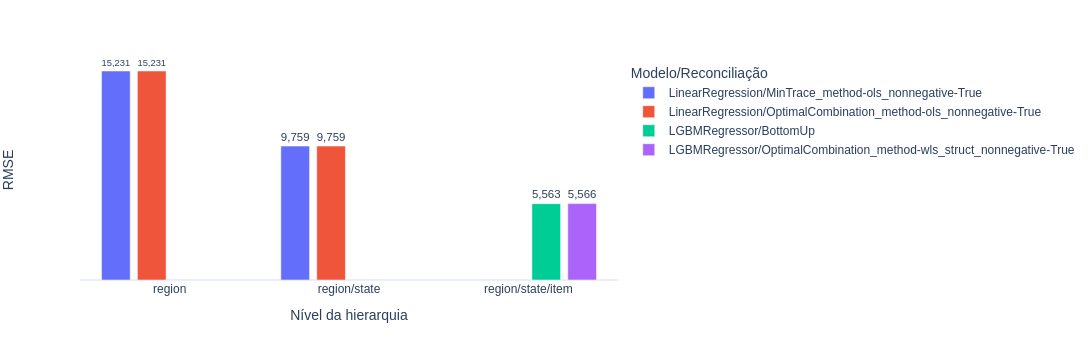

time: 857 ms (started: 2024-01-16 10:22:13 -03:00)


In [31]:
fig = px.bar(data_frame = df_metricas, 
             x = 'level',
             y = 'value',
             color = 'variable',
             barmode = 'group', 
             text = 'value_format', 
             template = 'plotly_white')

fig.update_layout(
    yaxis_title = 'RMSE',
    xaxis_title = 'Nível da hierarquia',
    legend_title = 'Modelo/Reconciliação',
    yaxis_visible = False,
    bargroupgap = 0.2,
    font = dict(
        size = 12
    )
)

fig.update_traces(
    textposition = 'outside'
)

fig.update_yaxes(
    visible = True,
    showticklabels = False, 
    showgrid = False
)

fig.show()

## 6. Dataframe com a tabela final

In [32]:
def create_final_df(df_pred: pd.DataFrame, cols_split: str):

    df1 = df_pred\
        .reset_index()\
        .assign(\
            nivel_hierarquia = lambda x: np.where(x['unique_id'].str.count('/') == 0, 1, x['unique_id'].str.count('/') + 1)
        )\
        .query('nivel_hierarquia == 3')
    
    df1[cols_split] = df1['unique_id'].str.split(pat = '/', n = len(cols_split), expand = True)
    
    df1 = df1[cols_split + ['ds'] + df1.select_dtypes(include = 'number').columns.tolist()]

    return df1

time: 860 µs (started: 2024-01-16 10:22:14 -03:00)


In [33]:
create_final_df(df_pred = Y_rec_df, cols_split = cols_hierarchical)

region      state           item         ds  \
4807   EastNorthCentral   Illinois  kids_clothing 2009-01-01   
4808   EastNorthCentral   Illinois  kids_clothing 2009-01-02   
4809   EastNorthCentral   Illinois  kids_clothing 2009-01-03   
4810   EastNorthCentral   Illinois  kids_clothing 2009-01-04   
4811   EastNorthCentral   Illinois  kids_clothing 2009-01-05   
...                 ...        ...            ...        ...   
23821      SouthCentral  Tennessee   womens_shoes 2009-07-24   
23822      SouthCentral  Tennessee   womens_shoes 2009-07-25   
23823      SouthCentral  Tennessee   womens_shoes 2009-07-26   
23824      SouthCentral  Tennessee   womens_shoes 2009-07-27   
23825      SouthCentral  Tennessee   womens_shoes 2009-07-28   

       LinearRegression  DecisionTreeRegressor  DecisionTreeRegressor2  \
4807             75.258                 77.000                  62.551   
4808             75.087                 74.000                  62.551   
4809             75.022                 75.000                  62.551   
4810             74.874                 75.000                  62.551   
4811             74.667                 75.000                  62.551   
...                 ...                    ...                     ...   
23821            38.419                 46.000                  29.576   
23822            38.455                 45.000                  29.576   
23823            38.489                 46.000                  29.576   
23824            38.534                 46.000                  29.576   
23825            38.578                 46.000                  29.576   

       RandomForestRegressor  RandomForestRegressor2  LGBMRegressor  ...  \
4807                  75.420                  49.630         74.925  ...   
4808                  74.722                  49.630         74.570  ...   
4809                  74.846                  49.630         74.633  ...   
4810                  74.080                  49.630         74.566  ...   
4811                  74.762                  49.630         74.593  ...   
...                      ...                     ...            ...  ...   
23821                 29.618                  25.717         30.889  ...   
23822                 29.366                  25.717         30.889  ...   
23823                 29.574                  25.717         30.883  ...   
23824                 29.690                  25.717         30.886  ...   
23825                 29.628                  25.717         30.885  ...   

       LinearRegression/OptimalCombination_method-wls_struct_nonnegative-True  \
4807                                              75.227                        
4808                                              75.031                        
4809                                              74.946                        
4810                                              74.781                        
4811                                              74.554                        
...                                                  ...                        
23821                                             34.325                        
23822                                             34.342                        
23823                                             34.358                        
23824                                             34.379                        
23825                                             34.400                        

       DecisionTreeRegressor/OptimalCombination_method-wls_struct_nonnegative-True  \
4807                                              76.200                             
4808                                              74.389                             
4809                                              74.811                             
4810                                              75.233                             
4811                                       

time: 71.8 ms (started: 2024-01-16 10:22:14 -03:00)


## 7. Feature importance, a partir dos modelos

**Retirado de https://mariofilho.com/como-prever-series-temporais-com-scikit-learn/**

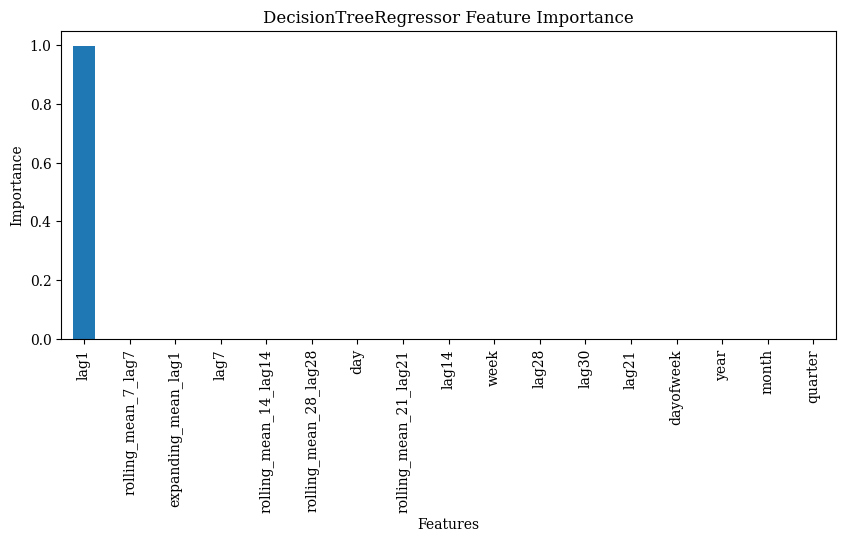

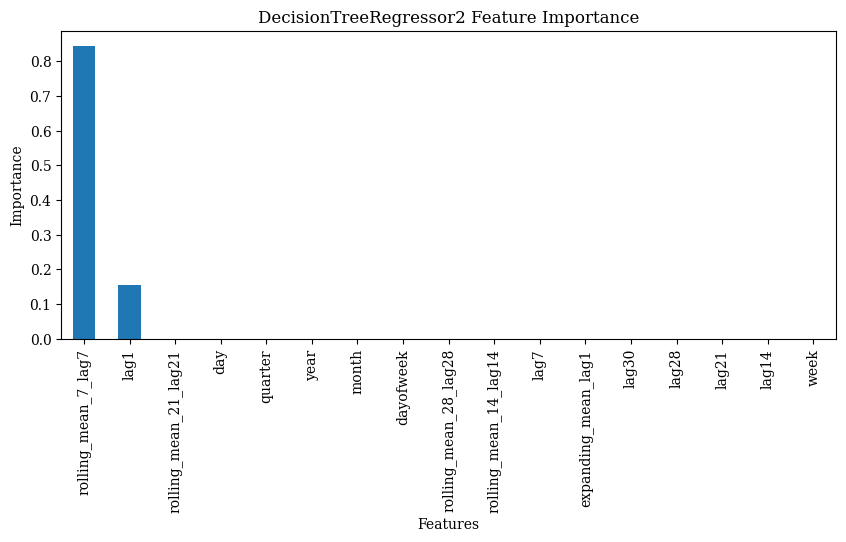

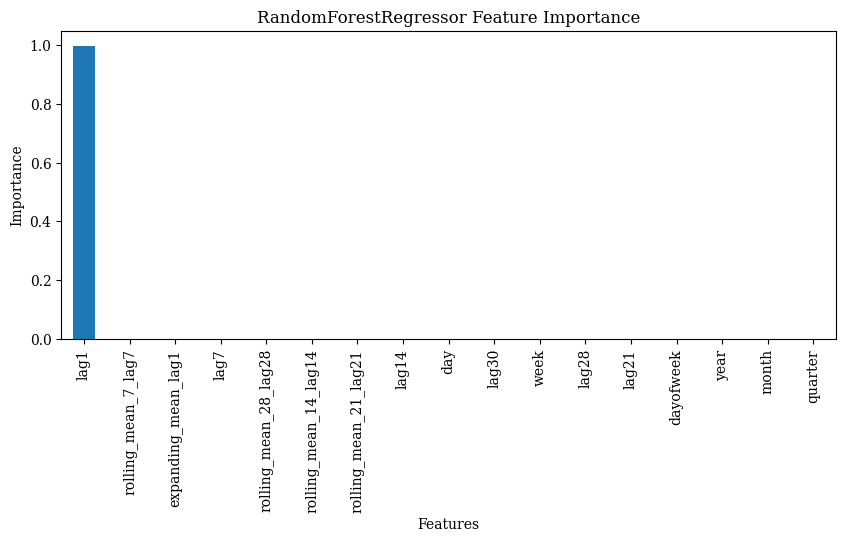

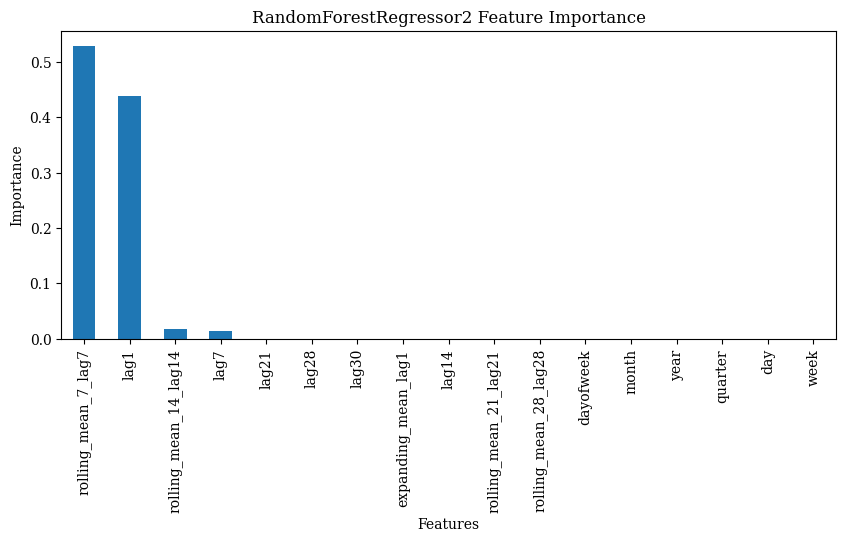

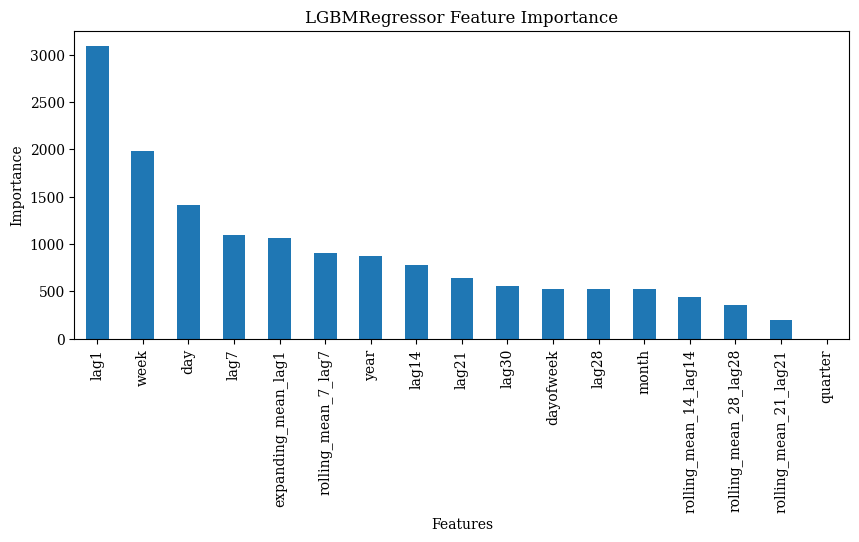

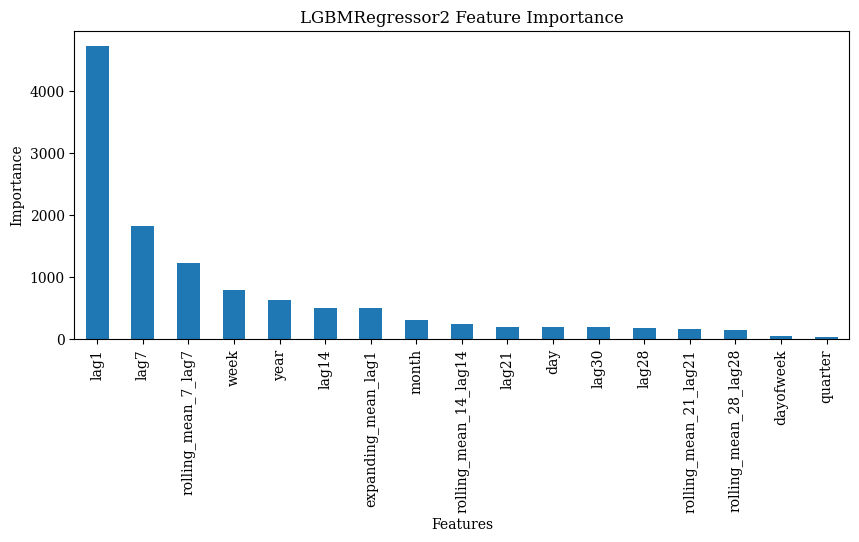

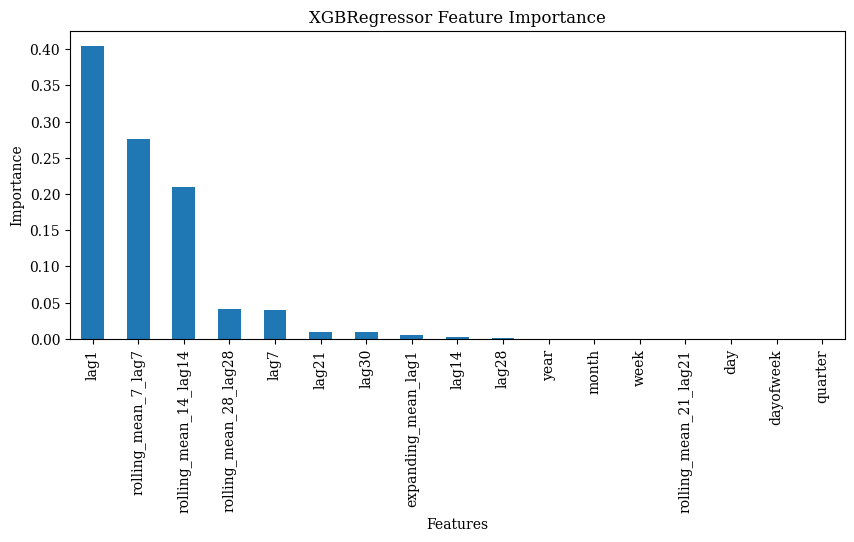

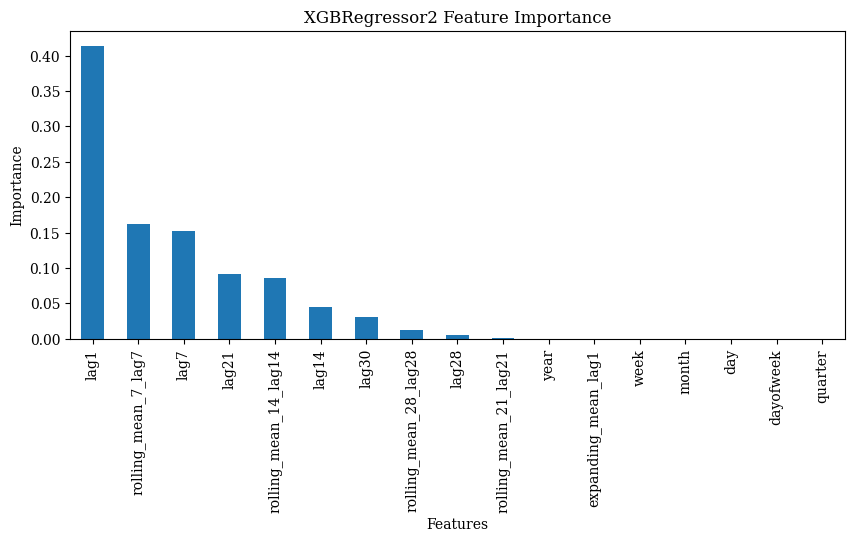

time: 38.3 s (started: 2024-01-16 10:22:14 -03:00)


In [34]:
import matplotlib.pyplot as plt

for mod in list(model.models_.keys()):

    if mod == 'LinearRegression':

        pass

    else:

        plt.figure(figsize = (10, 4))

        pd.Series(model.models_[mod].feature_importances_, 
                  index = model.ts.features_order_)\
            .sort_values(ascending = False)\
            .plot\
            .bar(title = f'{mod} Feature Importance',
                 xlabel = 'Features', 
                 ylabel = 'Importance')

## 8. Visualizações das projeções pelos níveis de agregação

In [35]:
from utilsforecast.plotting import plot_series

time: 34.5 ms (started: 2024-01-16 10:22:52 -03:00)


In [36]:
Y_rec_df.reset_index().merge(Y_valid_df.reset_index(), on = ['unique_id', 'ds'], how = 'left')\
    .query('unique_id == "SouthCentral/Tennessee/womens_shoes"')[['ds', 'y', 'LinearRegression/MinTrace_method-ols_nonnegative-True']]

ds   y  LinearRegression/MinTrace_method-ols_nonnegative-True
23617 2009-01-01  28                                             30.941    
23618 2009-01-02  31                                             30.928    
23619 2009-01-03  31                                             30.921    
23620 2009-01-04  29                                             30.736    
23621 2009-01-05  29                                             30.444    
...          ...  ..                                                ...    
23821 2009-07-24  31                                             32.197    
23822 2009-07-25  30                                             32.204    
23823 2009-07-26  31                                             32.212    
23824 2009-07-27  29                                             32.220    
23825 2009-07-28  30                                             32.228    

[209 rows x 3 columns]

time: 195 ms (started: 2024-01-16 10:22:52 -03:00)


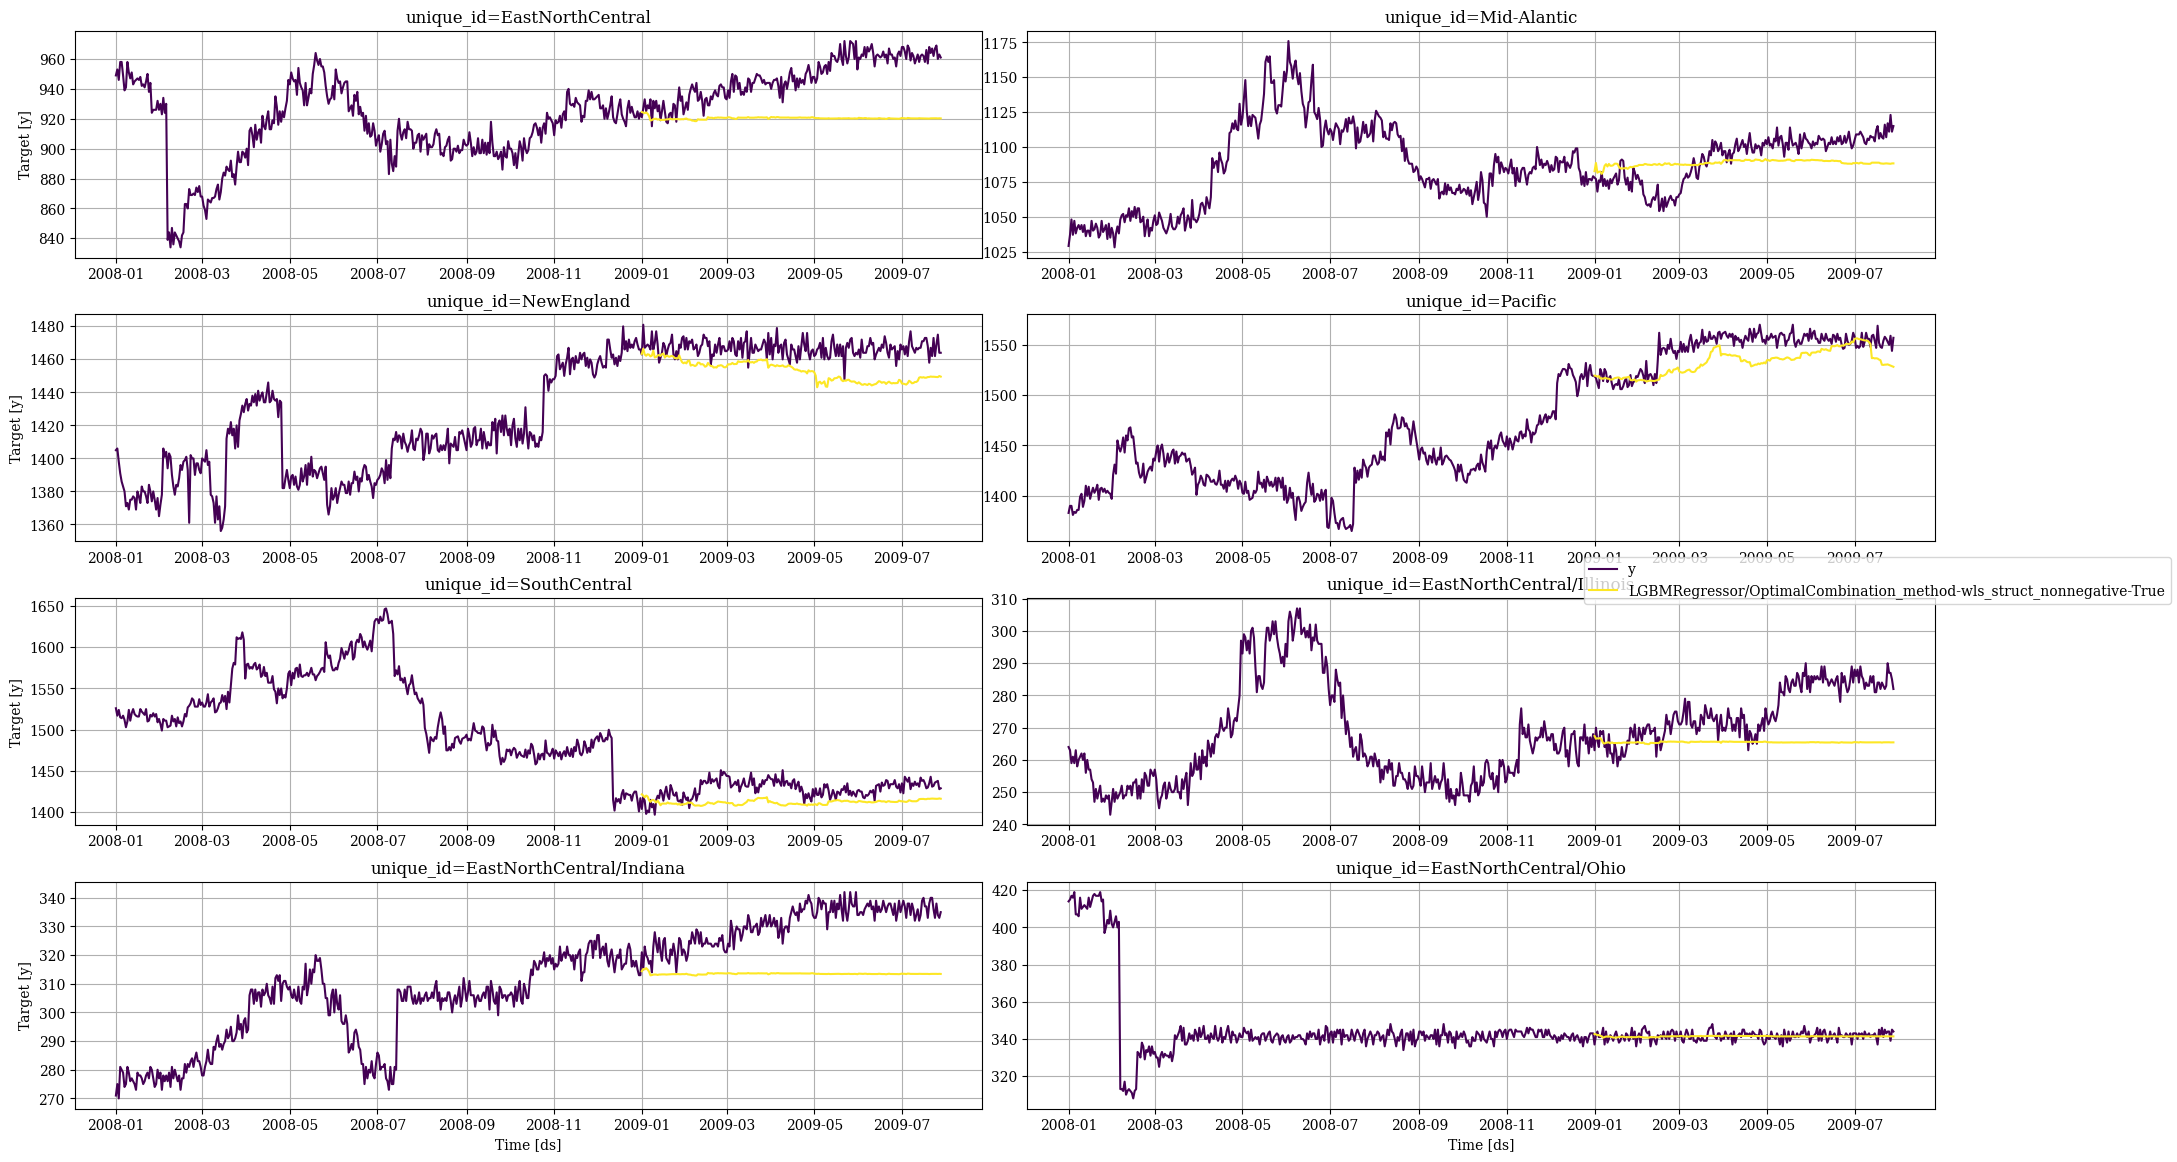

time: 1.62 s (started: 2024-01-16 10:22:53 -03:00)


In [37]:
plot_series(
    Y_train_df.reset_index().query('ds >= "2008-01-01"'), 
    Y_rec_df.reset_index().merge(Y_valid_df.reset_index(), on = ['unique_id', 'ds'], how = 'left'), 
    models = ['LGBMRegressor/OptimalCombination_method-wls_struct_nonnegative-True'],
    plot_random = False
    # ids = ['EastNorthCentral', 'EastNorthCentral/Illinois', 'EastNorthCentral/Illinois/womens_clothing']
)

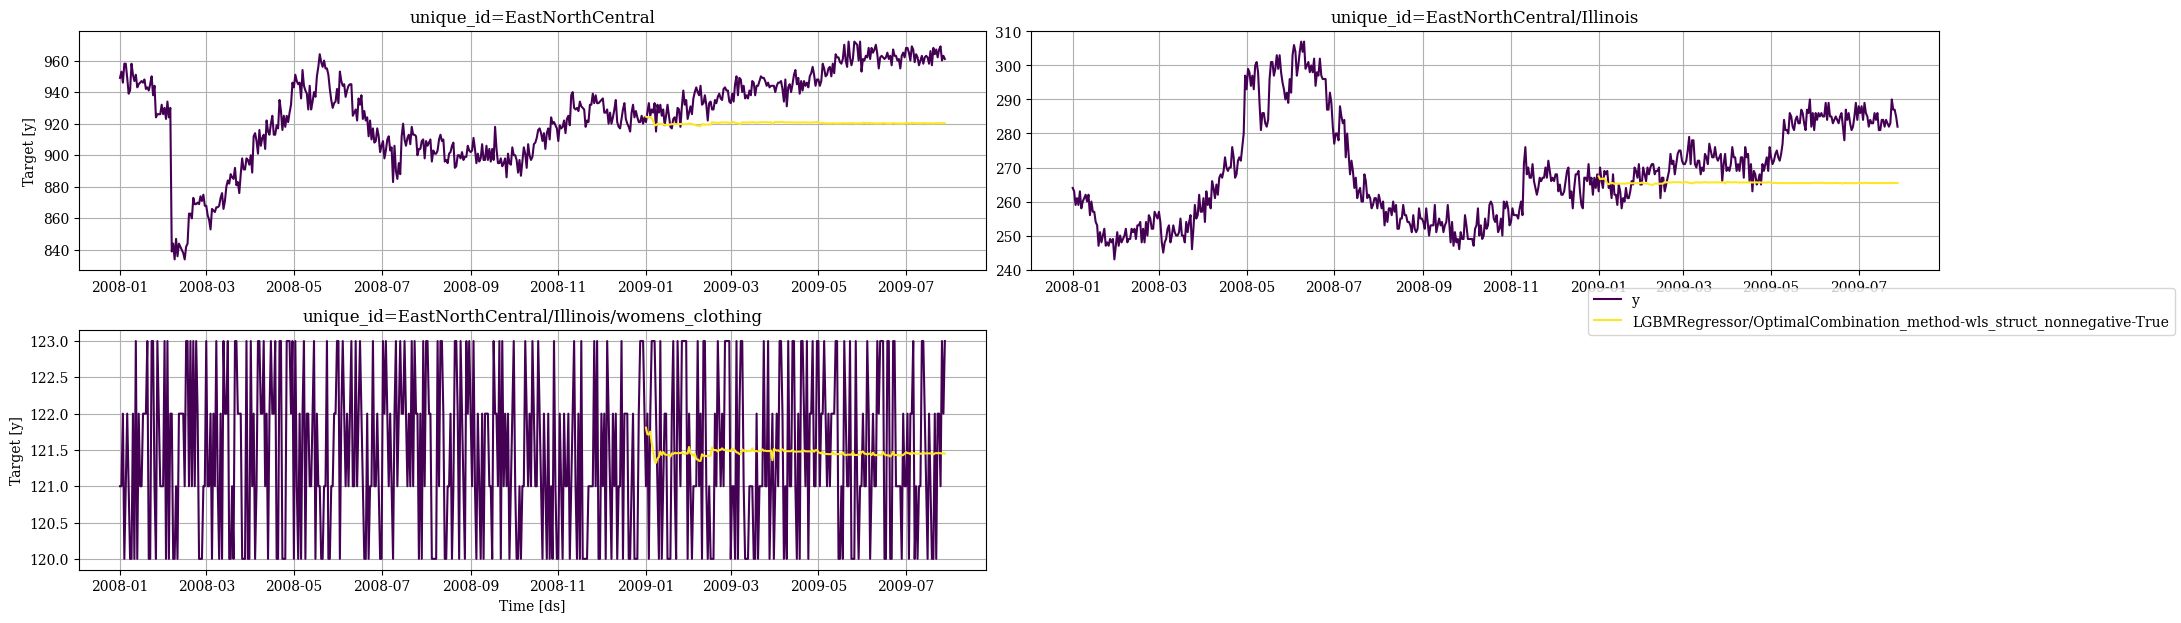

time: 778 ms (started: 2024-01-16 10:22:54 -03:00)


In [38]:
plot_series(
    Y_train_df.reset_index().query('ds >= "2008-01-01"'), 
    Y_rec_df.reset_index().merge(Y_valid_df.reset_index(), on = ['unique_id', 'ds'], how = 'left'), 
    models = ['LGBMRegressor/OptimalCombination_method-wls_struct_nonnegative-True'],
    plot_random = False,
    ids = ['EastNorthCentral', 'EastNorthCentral/Illinois', 'EastNorthCentral/Illinois/womens_clothing']
)